## HW 6: Intermarket prediction

$\textbf{Objective: }$ Predict the returns of the hedged CDS spread
$\textbf{How? }$ using boxcar and discounted least squares and then compare the 2 methods.

In [1]:
## Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl 
import functools
import seaborn as sns
import os
import datetime
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import plotnine as p9

import h5py
from IPython.display import display

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Get Data

The data is 5 years CDS rates for debt from several companies.

We cannot directly invest in CDS as we could for equities but they contain important information if we treat them similarly as equities. 

Spreads (just like prices) cannot go under 0 and have no upper limit

In [2]:
df_CDS = pd.read_csv('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/QTS/Liq5YCDS.delim', delimiter = '\t', index_col=0)
## set date to datetime
df_CDS['date'] = pd.to_datetime(df_CDS['date']) #, format='%Y%m%d'
## sort by date
df_CDS = df_CDS.sort_values(by='date')
df_CDS.head()

,date,ticker,tenor,parspread,upfront,runningcoupon,cdsrealrecovery,cdsassumedrecovery,docclause,currency,tier,impliedrating
0,2018-01-01,BA,5Y,0.001793,-0.228583,0.05,0.4,0.4,MR14,USD,SNRFOR,BBB
14,2018-01-01,XRX,5Y,0.018871,0.040426,0.01,0.4,0.4,MR14,USD,SNRFOR,BB
13,2018-01-01,XOM,5Y,0.003387,-0.220054,0.05,0.4,0.4,MR14,USD,SNRFOR,A
12,2018-01-01,WHR,5Y,0.005698,-0.208249,0.05,0.4,0.4,MR14,USD,SNRFOR,BBB
11,2018-01-01,WFC,5Y,0.004261,-0.215270,0.05,0.4,0.4,MR14,USD,SNRFOR,A


### Columns explanation

Tenor: Time to maturity of the CDS contract (always 5Y in our dataset)

parspread : spread in basis points that the buyer of the CDS pays to the seller annually to insure against default (cost of protection). It is a measure of the risk

upfront: this is an upfront payment the buyer pays to the seller to adjust for the difference between the runnning coupon and the market implied spread

runningcoupon: the fixed annual payment (in bp) made by the buyer of protection

cdsrealrecovery: the recovery rate (in %) in the event of default. It indicates the % of the notional amount that is expected to be recovered after a default

cdsassumerecovery: this is the assumed recovery rate, used to price the CDS contract

docclause: specify the documentation terms, the conditions under which a credit event triggers the CDS payout

tier: seniority of the debt being insured

impliedrating: this is the credit rating implied by the credit spread valuue. It provide a market based assessment of the credit risk, the entity's credit worthiness.

let check tha spreads are lower bounded by 0

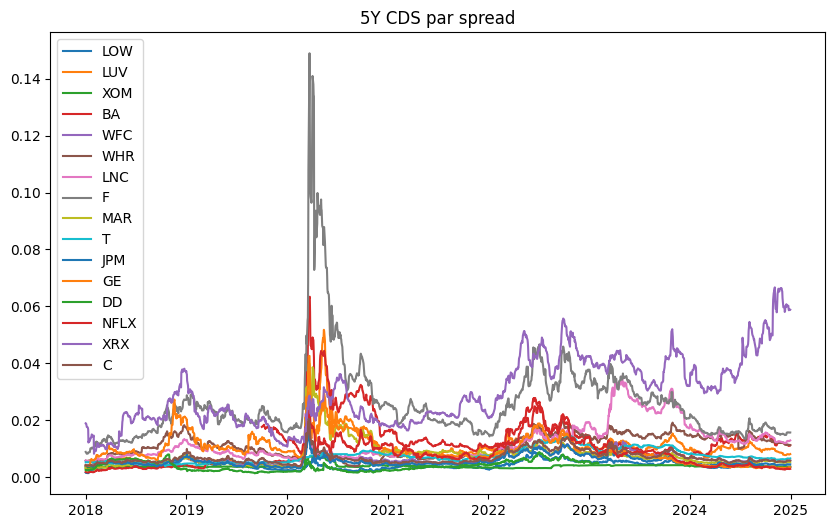

In [3]:
list_tickers = list(set(df_CDS['ticker']))

fig, ax = plt.subplots(figsize=(10, 6))

for ticker in list_tickers:
    df_temp = df_CDS[df_CDS['ticker'] == ticker]
    ax.plot(df_temp['date'], df_temp['parspread'], label=ticker)
    
ax.set_title('5Y CDS par spread')
ax.legend(loc='upper left')
plt.show()

we confirm that the credit spread value is lower bounded by 0 but can have very high value (no upper bound)

We also see that CDS went up a lot in 2020, likely due to COVID crisis that created uncertainty, and high risk are correlated with higher CDS

### load corresponding adj close price of corresponding equities.

In yfinance, the auto adjust argument has recently replaced the adj_close column

In [4]:
import yfinance as yf

list_tickers = list(set(df_CDS['ticker']))

start_date = df_CDS['date'].min().strftime('%Y-%m-%d')
end_date = df_CDS['date'].max().strftime('%Y-%m-%d')
print(start_date, end_date)

adj_close_price_equities = yf.download(list_tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
adj_close_price_equities.head()


2018-01-01 2024-12-31


[*********************100%***********************]  16 of 16 completed


Ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,WHR,XOM,XRX
Date,,,,,,,,,,,,,,,,
2018-01-02,282.886444,58.050426,88.996750,8.875398,81.634689,88.111282,58.125435,80.284523,61.270439,126.361992,201.070007,16.792316,49.709469,125.791489,60.593178,20.292570
2018-01-03,283.801270,58.229988,90.420212,8.945505,82.406540,88.201065,57.856861,80.635025,59.994946,128.912827,205.050003,16.404537,50.091919,126.428024,61.783257,20.264933
2018-01-04,282.724365,58.948189,92.153122,9.099738,84.131828,89.464607,58.886410,81.265953,59.800838,128.204285,205.630005,16.557034,50.718472,126.412994,61.868774,20.513670
2018-01-05,294.322296,58.870132,93.353783,9.253970,84.177254,88.890282,59.005772,83.018478,59.449612,126.976074,209.990005,16.618032,51.060223,126.158463,61.818905,20.665676
2018-01-08,295.570740,58.183144,93.031952,9.218918,82.996780,89.021553,58.893883,82.115921,59.153843,128.808914,212.050003,16.665964,50.482498,126.585220,62.096817,20.907503


In [5]:
## count missing values
print(adj_close_price_equities.isnull().sum())
print(set(adj_close_price_equities.index) - set(df_CDS['date']))

Ticker
BA      0
C       0
DD      0
F       0
GE      0
JPM     0
LNC     0
LOW     0
LUV     0
MAR     0
NFLX    0
T       0
WFC     0
WHR     0
XOM     0
XRX     0
dtype: int64
{Timestamp('2024-06-14 00:00:00'), Timestamp('2024-10-04 00:00:00')}


### Compute weekly returns of the adj_close price and CDS value

get wednesday to wednesday returns

In [6]:
## get parspread pivoted CDS dataset, I want date and ticker as columns

df_CDS_spread = df_CDS.pivot(index = 'date', columns='ticker', values='parspread')
df_CDS_spread.index = pd.to_datetime(df_CDS_spread.index)
df_CDS_spread.head()


ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,WHR,XOM,XRX
date,,,,,,,,,,,,,,,,
2018-01-01,0.001793,0.004113,0.002476,0.008805,0.004037,0.003901,0.005817,0.001546,0.003107,0.003588,NaN,0.005179,0.004261,0.005698,0.003387,0.018871
2018-01-02,0.001768,0.004100,0.002483,0.008663,0.004077,0.003855,0.005783,0.001450,0.003068,0.002330,NaN,0.005181,0.004226,0.005578,0.003404,0.018839
2018-01-03,0.001682,0.004080,0.002425,0.008474,0.004076,0.003763,0.005742,0.001510,0.002989,0.002351,NaN,0.005180,0.004190,0.005599,0.003408,0.018579
2018-01-04,0.001659,0.003968,0.002374,0.008306,0.004025,0.003752,0.005602,0.001397,0.002880,0.002314,NaN,0.005180,0.004217,0.005634,0.003407,0.018024
2018-01-05,0.001634,0.003909,0.002411,0.008158,0.003995,0.003711,0.005595,0.001394,0.002772,0.002317,NaN,0.005179,0.004155,0.005644,0.003404,0.017598


In [7]:
## missing values
print(df_CDS_spread.isnull().sum())

ticker
BA        0
C         0
DD      495
F         0
GE        0
JPM       0
LNC       0
LOW       0
LUV       0
MAR       0
NFLX    459
T         0
WFC       0
WHR       0
XOM       0
XRX       0
dtype: int64


We can see that we have data issues for adj close price but we miss a lot of data for NFLX and DD 5Y CDS. We might wanna discard them in the future

In [8]:
list_tickers = list(set(list_tickers) - set(['NFLX', 'DD']))
print(list_tickers)

['LUV', 'XOM', 'BA', 'WFC', 'LNC', 'F', 'GE', 'C', 'LOW', 'WHR', 'MAR', 'T', 'JPM', 'XRX']


In [9]:
## get wednesday to wednesday returns of equities adjusted close prices and CDS par spread

## get wednesday dates
df_CDS_spread['weekday'] = df_CDS_spread.index.day_name()
wednesday_dates = df_CDS_spread[df_CDS_spread['weekday'] == 'Wednesday'].index

# ## get wednesday to wednesday returns for CDS
CDS_wednesday_to_wednesday = df_CDS_spread[df_CDS_spread.index.isin(wednesday_dates)].copy()
for ticker in list_tickers:
    CDS_wednesday_to_wednesday[ticker + '_CDS_return'] = CDS_wednesday_to_wednesday[ticker].pct_change()
CDS_wednesday_to_wednesday = CDS_wednesday_to_wednesday.dropna()

## get wednesday to wednesday returns for equities adj close prices
adj_close_price_equities['weekday'] = adj_close_price_equities.index.day_name()
adj_close_price_equities_wednesday = adj_close_price_equities[adj_close_price_equities.index.isin(wednesday_dates)].copy()
for ticker in list_tickers:
    adj_close_price_equities_wednesday[ticker + '_return'] = adj_close_price_equities_wednesday[ticker].pct_change()
adj_close_price_equities_wednesday = adj_close_price_equities_wednesday.dropna()

## get market equity wednesday to wednesday return on SPY
spy_data = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)['Close']
spy_data['weekday'] = spy_data.index.day_name()
spy_data_wednesday = spy_data[spy_data.index.isin(wednesday_dates)].copy()
spy_data_wednesday['SPY_return'] = spy_data_wednesday['SPY'].pct_change()
spy_data_wednesday = spy_data_wednesday.dropna()


spy_data_wednesday.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY,weekday,SPY_return
Date,,,
2018-01-10,244.770966,Wednesday,0.013495
2018-01-17,249.673218,Wednesday,0.020028
2018-01-24,252.860962,Wednesday,0.012768
2018-01-31,251.718002,Wednesday,-0.004520
2018-02-07,239.011612,Wednesday,-0.050479


let see how equity returns move with CDS returns

we check for 4 differents equities: BA, C, DD, F

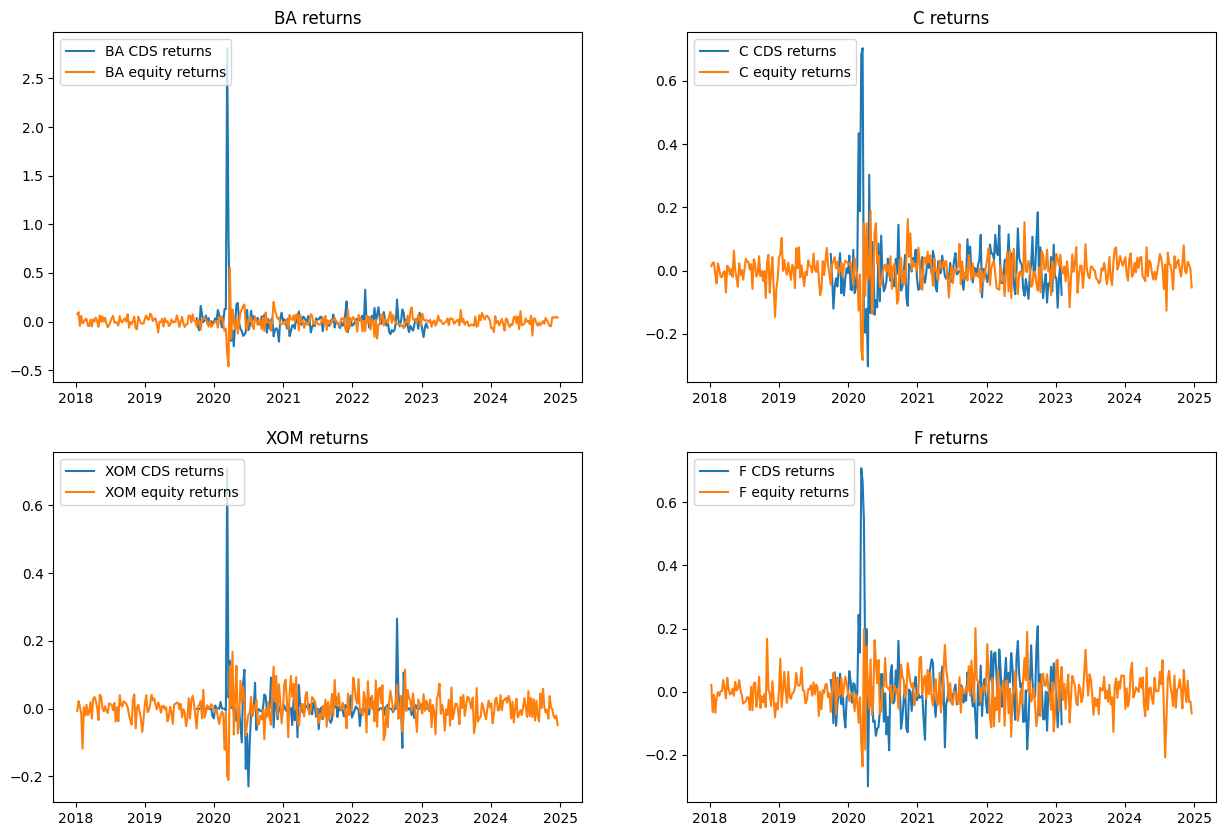

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

ax[0,0].plot(CDS_wednesday_to_wednesday.index, CDS_wednesday_to_wednesday['BA_CDS_return'], label='BA CDS returns')
ax[0,0].plot(adj_close_price_equities_wednesday.index, adj_close_price_equities_wednesday['BA_return'], label='BA equity returns')
ax[0,0].set_title('BA returns')
ax[0,0].legend(loc='upper left')

ax[0,1].plot(CDS_wednesday_to_wednesday.index, CDS_wednesday_to_wednesday['C_CDS_return'], label='C CDS returns')
ax[0,1].plot(adj_close_price_equities_wednesday.index, adj_close_price_equities_wednesday['C_return'], label='C equity returns')
ax[0,1].set_title('C returns')
ax[0,1].legend(loc='upper left')

ax[1,0].plot(CDS_wednesday_to_wednesday.index, CDS_wednesday_to_wednesday['XOM_CDS_return'], label='XOM CDS returns')
ax[1,0].plot(adj_close_price_equities_wednesday.index, adj_close_price_equities_wednesday['XOM_return'], label='XOM equity returns')
ax[1,0].set_title('XOM returns')
ax[1,0].legend(loc='upper left')

ax[1,1].plot(CDS_wednesday_to_wednesday.index, CDS_wednesday_to_wednesday['F_CDS_return'], label='F CDS returns')
ax[1,1].plot(adj_close_price_equities_wednesday.index, adj_close_price_equities_wednesday['F_return'], label='F equity returns')
ax[1,1].set_title('F returns')
ax[1,1].legend(loc='upper left')

plt.show()

We can see that the amplitude of returns are quite similar except the 2020 spikes for CDS returns that are not well represented in the equity returns

## Models

We want to that idiosynchratic returns of the equity returns 'c' can be used to predict future idiosynchratic returns of spreads '$\rho$' (idiosynchratic mean the returns that are not explained by a market movement, i.e specific to the asset itself)

$\textbf{Getting idiosynchratic equity returns 'c'}$: We use a 1-factor model (CAPM) to go from pure equity returns r to the idiosynchratic ones c (just take residuals of the model). USe a contemporaneous model (because we want to get the unexplicable returns)

$\textbf{Getting idiosynchratic equity returns 'rho'}$: We use a 2-factor model (based on the same company equity returns and an CDS market returns)  model to go from pure CDS returns to the idiosynchratic ones $\rho$ (just take residuals of the model). We will construct the CDS market returns as the avg returns of all CDS returns we have. Use a contemporaneous regression model (because we want to get the unexplicable returns)


We will use zero-intercept regression: Y = $\beta_1 X_1$ + ... + $\beta_n X_n$ + $\epsilon$

Therefore: $\beta = (X^T X)^{-1}X^T Y$

$\textbf{regress rho angainst c with both boxcar and exponential decay models}$: We will use a predictive model



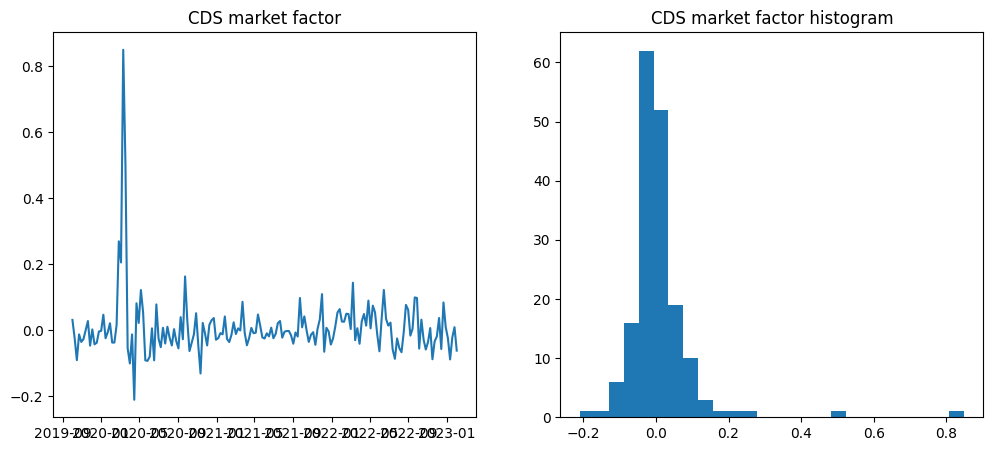

In [11]:
## add CDS market factor as the average of all CDS returns
CDS_wednesday_to_wednesday['CDS_market'] = CDS_wednesday_to_wednesday[[col for col in CDS_wednesday_to_wednesday.columns if '_return' in col]].mean(axis=1)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].plot(CDS_wednesday_to_wednesday.index, CDS_wednesday_to_wednesday['CDS_market'])
ax[0].set_title('CDS market factor')
ax[1].hist(CDS_wednesday_to_wednesday['CDS_market'], bins = 2*int(np.sqrt(len(CDS_wednesday_to_wednesday['CDS_market']))))
ax[1].set_title('CDS market factor histogram')
plt.show()

We can observe that the CDS market returns are normally distributed

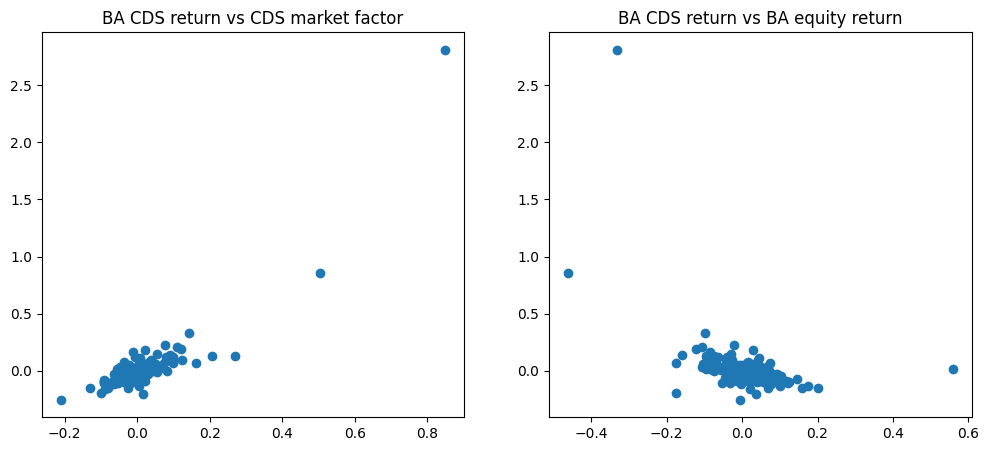

In [12]:
## CDS vs equity returns
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].scatter(CDS_wednesday_to_wednesday['CDS_market'], CDS_wednesday_to_wednesday['BA_CDS_return'], label='BA')
ax[0].set_title('BA CDS return vs CDS market factor')
temp_data = pd.concat([adj_close_price_equities_wednesday['BA_return'], CDS_wednesday_to_wednesday['BA_CDS_return']], axis=1).dropna()
ax[1].scatter(temp_data['BA_return'], temp_data['BA_CDS_return'], label='BA')
ax[1].set_title('BA CDS return vs BA equity return')
plt.show()

$\textbf{Commentary}$: One can see that except some outliers (that are probably some data in 2020), the CDS returns are quite linearly related to CDS market returns (positively) and to equity adj close price returns (negatively). Therefore, a linear regression should make sense (i.e there is a systematic explanation of the returns and some idiosynchraticity of each equity CDS returns).

Similarly, I could show the linear relationship between an equity return and the SPY 500

### 1st step: Get idiosynchratique returns rho and c

to do so we run contemporaneous models (and use boxcar regression)

<!-- 1. For predictive models: -->

$\textbf{Boxcar OLS}$: The box car function takes values 1 in an intervall [a,b] and 0 outside of it. Therefore the box car regression of window size G means to run a linear regression model on the past G values

<!-- $\textbf{Exponentially weighted moving regression}$: In this regression model we want to solve:
$$
WLS : \sum_i w_i(y_i-\beta x_i)x_i = 0 \Rightarrow \quad \beta = 
$$
Where $w_i = \frac{\lambda^i}{\sum_i^{n}\lambda^i}$ whith lambda chosen s.t $0.5 = \sum_i^{H}\lambda^i$ (half-life)

While OLS is:
$$
\sum_i (y_i-\beta x_i)x_i = 0
$$ -->


To get rho we run a regression on each CDS return: $r_E^{CDS}$ ~ $r_E^{equity} + r_{index}^{CDS}$

To get c we run a regression on each market equity return: $r_E^{equity}$ ~ $r_{SPY} $

Since we need at least G weeks of returns, we start at week G+1

Rho and c will just be the residuals of the 2 factor and CAPM model respectively


### 1.1 Contemporaneous boxcar regressio for equity CDS: get rho

1. Without vectorizing

2. with vectorization (using rollin regression)

In [13]:
import statsmodels.api as sm

## parameters setting

G = 20 ## nber of weeks for regression
start_index = CDS_wednesday_to_wednesday.index[G]


LUV
XOM
BA
WFC
LNC
F
GE
C
LOW
WHR
MAR
T
JPM
XRX


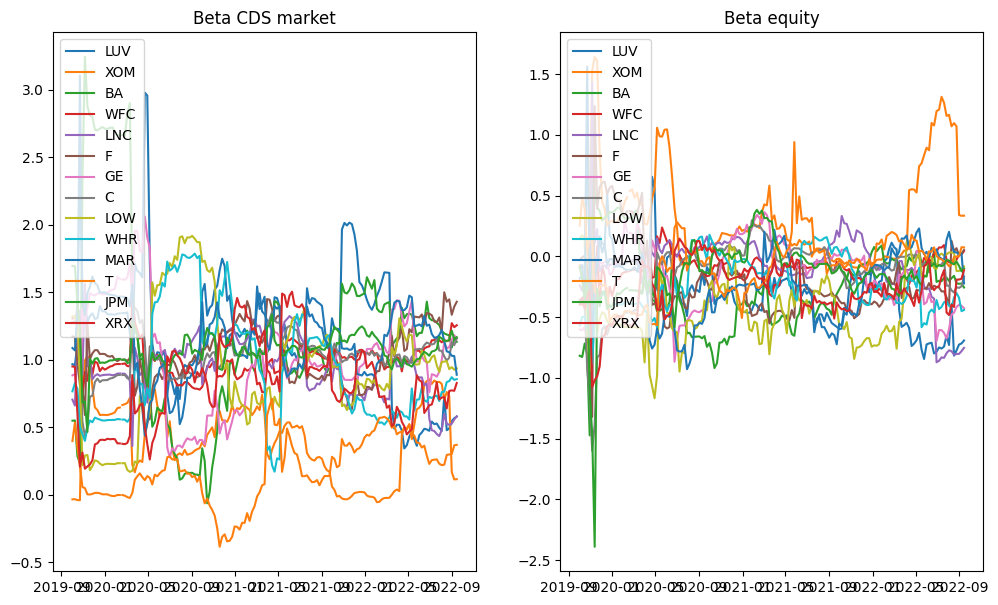

In [14]:
## Without vectorization


## run regression for each CDS with index CDS factor and equity adj close price factor
## we set alpha to be 0 by not adding constant to the regression

## define start index as G+1 week
beta_index = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index[G:])
beta_equity = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index[G:])

for ticker in list_tickers:
    print(ticker)
    for i in range(G, len(CDS_wednesday_to_wednesday)):
        dates = CDS_wednesday_to_wednesday.index[i-G:i]
        equity_CDS_returns = CDS_wednesday_to_wednesday[ticker + '_CDS_return'][i-G:i] ##output y
        CDS_market = CDS_wednesday_to_wednesday['CDS_market'][i-G:i] ## predictor x1
        equity_market_returns = adj_close_price_equities_wednesday[ticker + '_return'][adj_close_price_equities_wednesday.index.isin(dates)] ## predictor x2
        
        temp_data = pd.concat([equity_CDS_returns, CDS_market, equity_market_returns], axis=1).copy()
        temp_data = temp_data.dropna()
        
        if len(temp_data) < int(5):
            print('skip')
            continue
        
        X = temp_data[['CDS_market', ticker + '_return']]
        y = temp_data[ticker + '_CDS_return']
        model = sm.OLS(y, X).fit()
        beta_index.loc[CDS_wednesday_to_wednesday.index[i-G], ticker] = model.params['CDS_market']
        beta_equity.loc[CDS_wednesday_to_wednesday.index[i-G], ticker] = model.params[ticker + '_return']
    
## plot results
fig, ax = plt.subplots(1,2, figsize=(12, 7))
for ticker in list_tickers:
    ax[0].plot(beta_index.index, beta_index[ticker], label=ticker)
ax[0].set_title('Beta CDS market')
ax[0].legend(loc='upper left')
for ticker in list_tickers:
    ax[1].plot(beta_equity.index, beta_equity[ticker], label=ticker)
ax[1].set_title('Beta equity')
ax[1].legend(loc='upper left')

plt.show()



We first notice that we do not skip any week because of some lack of data.

Second, we see that the beta values vary a lot. Probably that the larger the window is, the less volatile are the betas

Finally, I want to add that in my regression I use i-G (where G is 20) and I assume that this means we go back to 20 weeks before because no missing data. Otherwise, we would be looking for the date which is the nearest to 20 weeks ago

Processing ticker: LUV
Processing ticker: XOM
Processing ticker: BA
Processing ticker: WFC
Processing ticker: LNC
Processing ticker: F
Processing ticker: GE
Processing ticker: C
Processing ticker: LOW
Processing ticker: WHR
Processing ticker: MAR
Processing ticker: T
Processing ticker: JPM
Processing ticker: XRX


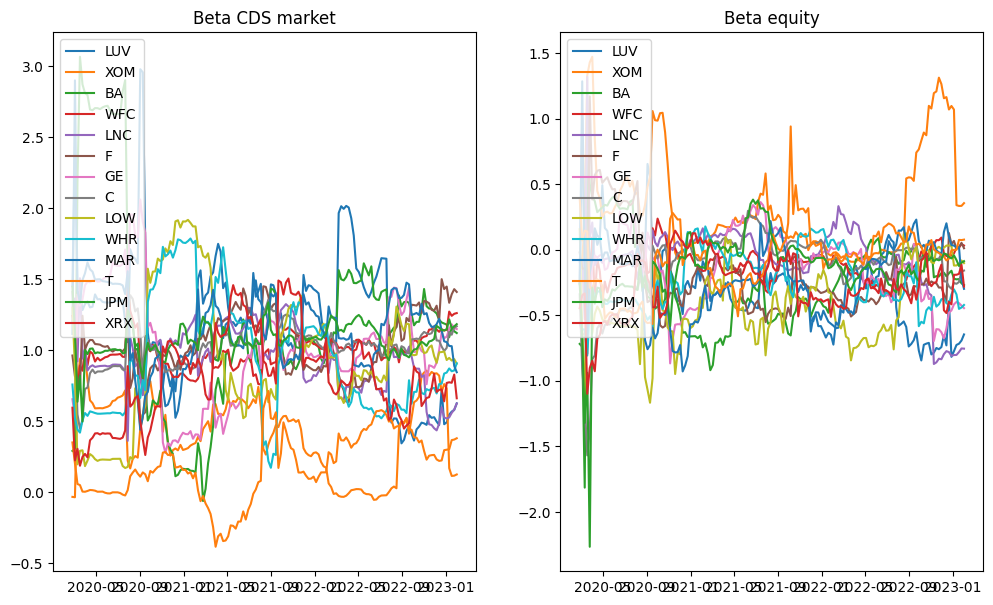

In [15]:
from statsmodels.regression.rolling import RollingOLS
## With vectorization

# Here we use the full index of CDS_wednesday_to_wednesday.
beta_index = pd.DataFrame(index=CDS_wednesday_to_wednesday.index, columns=list_tickers, dtype=float)
beta_equity = pd.DataFrame(index=CDS_wednesday_to_wednesday.index, columns=list_tickers, dtype=float)

for ticker in list_tickers:
    print("Processing ticker:", ticker)

    y = CDS_wednesday_to_wednesday[ticker + '_CDS_return']
    X = pd.merge(CDS_wednesday_to_wednesday['CDS_market'], adj_close_price_equities_wednesday[ticker + '_return'], left_index=True, right_index=True)
    combined = pd.concat([y, X], axis=1).dropna()
    
    #  if there isn’t enough data for a rolling window add nan values.
    if len(combined) < int(5):
        beta_index[ticker] = np.nan
        beta_equity[ticker] = np.nan
        continue
    
    # Fit the rolling regression and We do not add a constant since alpha is set to zero.
    rolling_model = RollingOLS(endog=combined[ticker + '_CDS_return'],
                               exog=combined[['CDS_market', ticker + '_return']],
                               window=G)
    rolling_res = rolling_model.fit()
    
    # The fitted model returns a DataFrame of parameters with indices corresponding to the last date of each full window.
    params = rolling_res.params

    # Store the estimated coefficients in our beta DataFrames.
    beta_index.loc[params.index, ticker] = params['CDS_market']
    beta_equity.loc[params.index, ticker] = params[ticker + '_return']

# beta_index = beta_index.dropna(how='all')
# beta_equity = beta_equity.dropna(how='all')

fig, ax = plt.subplots(1,2, figsize=(12, 7))
for ticker in list_tickers:
    ax[0].plot(beta_index.index, beta_index[ticker], label=ticker)
ax[0].set_title('Beta CDS market')
ax[0].legend(loc='upper left')
for ticker in list_tickers:
    ax[1].plot(beta_equity.index, beta_equity[ticker], label=ticker)
ax[1].set_title('Beta equity')
ax[1].legend(loc='upper left')

plt.show()


1st we can see how mcuh vectorization accelerate the process (4.5 sec vs 0.6 sec). We can confirm visually that the results are similar. In the future we will use the vectorize version

Even though the number of plots makes it not very easy to read, we can see that the CDS market index has a beta varying around 0 and 3 while the beta of the equity is around -1 and 1 (slightly negative on average). This scale difference of those betas can be explained by the scale difference between CDS index returns and equity market returns (as we wan see in a previous plot show CDS returns and equity returns, where we can see that equity returns tend to be lower in absolute value)


In [16]:
print(beta_index.isna().sum())
beta_index = beta_index.dropna(how='all')
beta_index

LUV    21
XOM    21
BA     21
WFC    21
LNC    21
F      21
GE     21
C      21
LOW    21
WHR    21
MAR    21
T      21
JPM    21
XRX    21
dtype: int64


,LUV,XOM,BA,WFC,LNC,F,GE,C,LOW,WHR,MAR,T,JPM,XRX
date,,,,,,,,,,,,,,
2020-02-26,1.113978,-0.033684,0.290061,1.240231,1.189963,0.961584,0.653768,1.409053,1.297936,0.757369,1.449875,0.349554,1.445527,0.594199
2020-03-04,2.898654,-0.036297,0.308398,1.154466,1.363373,0.814843,0.529368,1.063015,0.874191,0.523373,2.436282,0.203885,1.135425,0.223484
2020-03-11,1.409114,0.759967,2.182691,0.703405,0.920105,0.808232,1.392024,0.546598,0.195610,0.440733,1.417646,0.057113,0.636255,0.304611
2020-03-18,1.406973,0.936285,3.064756,0.891071,1.505611,0.735952,1.312359,0.444584,0.290528,0.418735,1.331310,0.049311,0.819399,0.185561
2020-03-25,1.281759,0.963447,2.869924,0.854534,0.939793,1.241613,1.357157,0.509480,0.294264,0.504550,1.492829,0.003598,0.496555,0.247718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-04,0.491117,0.730238,1.179781,1.143492,0.518004,1.446919,1.094325,1.015520,0.930120,0.841672,1.055534,0.298334,1.146512,0.768539
2023-01-11,0.544946,0.168616,1.090587,1.270923,0.526188,1.332863,1.147765,1.128611,0.944992,0.870654,1.028812,0.301807,1.216053,0.773092
2023-01-18,0.566658,0.113821,1.158826,1.240954,0.557708,1.392550,1.181132,1.107981,0.925948,0.850803,1.027259,0.366059,1.153421,0.769674


because this rolling OLS store all the dates, we need to remove the G+1 first NaN values for beta

In [17]:
## AVG beta equity
avg_beta_equity = beta_equity.mean(axis=1).mean()
avg_beta_CDS_index = beta_index.mean(axis=1).mean()
print('Average beta equity:', avg_beta_equity)
print('Average beta CDS index:', avg_beta_CDS_index)

Average beta equity: -0.15987952410668643
Average beta CDS index: 0.926016678163598


$\textbf{Analysis}$: We can see that on average the BDS index beta is around 92% wich makes sense because this represents the average of all CDS returns. Therefore a high positive correlation is coherent (as a SP500 stock would be highly positively correlated to the SP500 index). More, the average of the equity beta is around -16%. This negative correlation is coherent because when the equity goes well (more stable, less risky), the CDS price should go down (due to less risk) and inversely.

### 1.2 CAPM contemporaneous  boxcar regression: get c

Processing ticker: LUV
Processing ticker: XOM
Processing ticker: BA
Processing ticker: WFC
Processing ticker: LNC
Processing ticker: F
Processing ticker: GE
Processing ticker: C
Processing ticker: LOW
Processing ticker: WHR
Processing ticker: MAR
Processing ticker: T
Processing ticker: JPM
Processing ticker: XRX


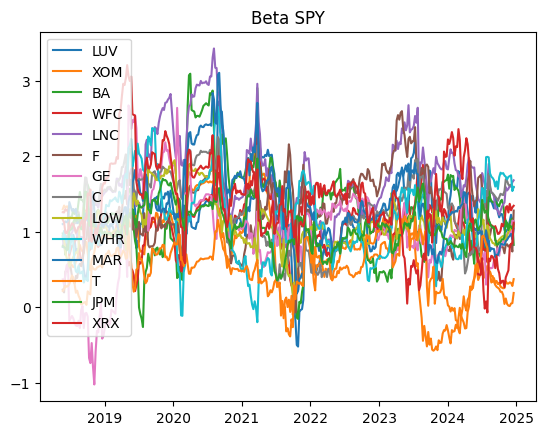

In [18]:
## With vectorization


beta_spy = pd.DataFrame(index=adj_close_price_equities.index, columns=list_tickers, dtype=float)

for ticker in list_tickers:
    print("Processing ticker:", ticker)
    y = adj_close_price_equities_wednesday[ticker + '_return']
    # X is a DataFrame with the market CDS factor and the equity return for the ticker.
    X = spy_data_wednesday['SPY_return']
        
    # combined = pd.concat([y, X], axis=1).dropna()
    combined = pd.merge(y, X, left_index=True, right_index=True)
    
    # Fit the rolling regression and We do not add a constant since alpha is set to zero.
    rolling_model = RollingOLS(endog=combined[[ticker + '_return']],
                               exog=combined[['SPY_return']],
                               window=G)
    rolling_res = rolling_model.fit()
    
    # The fitted model returns a DataFrame of parameters with indices corresponding to the last date of each full window.
    params = rolling_res.params

    # Store the estimated coefficients in our beta DataFrames.
    beta_spy.loc[params.index, ticker] = params['SPY_return']

beta_spy = beta_spy.dropna(how='all')
# R2 = R2.dropna(how='all')

for ticker in list_tickers:
    plt.plot(beta_spy.dropna(how='all').index, beta_spy.dropna(how='all')[ticker], label=ticker)
plt.title('Beta SPY')
plt.legend(loc='upper left')

plt.show()

$\textbf{Commentary}$: we can see more consistency on the beta values for the CAPM model (because as see previously, we have less extreme values for equity market returns than equity CDS returns)

## 2. Regress 2-factors residuals (rho) against CAPM residuals c

This time we to predict rho with c, therefore we will use a predictive model (and not a contemporaneous model as previously)

2.1 : use boxcar regression method

2.2 use a exponential decay weights method

for comparing those 2 methods, we can avg the returns (instead of doing company by company). Expo decay should be more preferable

Here is the regression, for each equity E and each week n:
$$ \rho_{E,n} = \mu_{E,n}c_{E,n} + q_{E,n}$$

where $q_{E,n}$ are the residuals of the predictive model at week n for equity E.

Note that $\rho_{E,n}$ is an array of residuals for the 2 factor model, as well as $c_{E,n}$ are the residuals of the CAPM model. However, we should note that we discarded some weeks for some equity in the previous regression because of the lack of data. Therefore, for each equity we can the regression at week n only if we were able to both contemporaneous regression

LUV
XOM
BA
WFC
LNC
F
GE
C
LOW
WHR
MAR
T
JPM
XRX


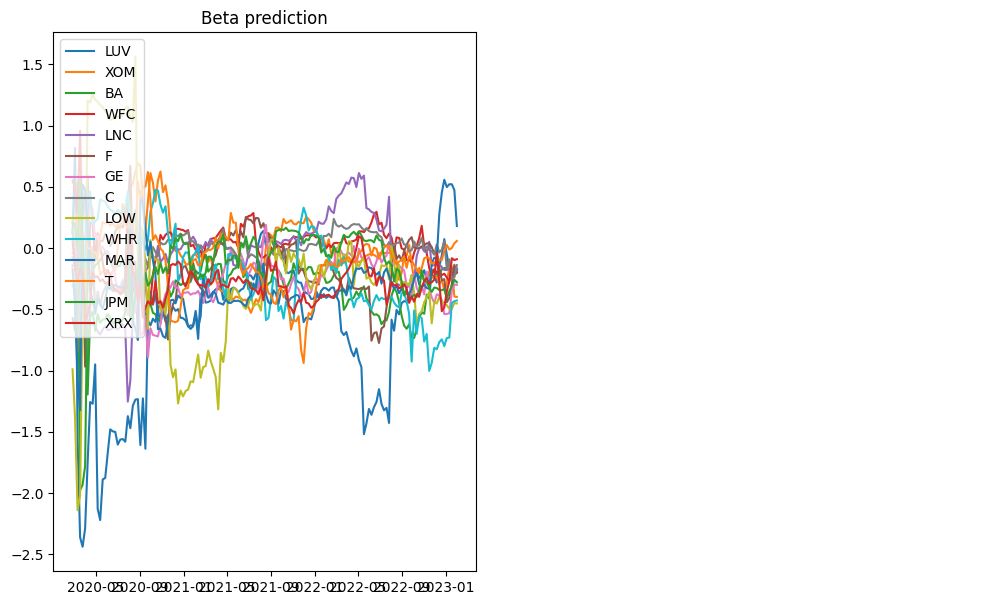

In [19]:
## boxcar method to regress rho (error of 2 factor model) against c (error of capm model) lagged by 1 week

## get residuals for each ticker and each week q_{E,n}
## dataframe for residuals
beta_pred = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index[G:])

for ticker in list_tickers:
    print(ticker)

    for i in range(G+1, len(CDS_wednesday_to_wednesday)):
        ## i is the week for rho and j =  i-1 is the week for c
        date_i = CDS_wednesday_to_wednesday.index[i]
        dates_rho = CDS_wednesday_to_wednesday.index[i-G:i]
        dates_rho = dates_rho.intersection(adj_close_price_equities_wednesday.index)  ## keep valid dates
        j = i-1
        date_j = CDS_wednesday_to_wednesday.index[j]
        dates_c = CDS_wednesday_to_wednesday.index[j-G:j]
        dates_c = dates_c.intersection(spy_data_wednesday.index)  ## keep valid dates
        
        ## check if there is enough data for the regression: we need 2factor reg for week i and and CAPM for week j
        beta_index_i = beta_index[ticker].loc[date_i]
        beta_equity_i = beta_equity[ticker].loc[date_i]
        beta_spy_j = beta_spy[ticker].loc[date_j]
        condition = np.isnan(beta_equity_i) or np.isnan(beta_index_i) or np.isnan(beta_spy_j)
        if condition:
            # print('Not enough data for ticker', ticker, 'at week', i)
            beta_pred.loc[date_i, ticker] = np.nan
            ## go to next week
        else:
            CDS_returns_i = CDS_wednesday_to_wednesday.loc[dates_rho][ticker +'_CDS_return']
            CDS_market_i = CDS_wednesday_to_wednesday.loc[dates_rho]['CDS_market']
            equity_return_i = adj_close_price_equities_wednesday.loc[dates_rho][ticker + '_return']
            spy_return_j = spy_data_wednesday.loc[dates_c]['SPY_return']
            equity_return_j = adj_close_price_equities_wednesday.loc[dates_c][ticker + '_return']
            
            # rho array from the regression on ticker and at week i: rho = returns - beta_index * CDS_market - beta_equity * equity
            rho = CDS_returns_i - beta_index_i * CDS_market_i - beta_equity_i * equity_return_i
            ## get c array from the CAPM regression on ticker and at week j=i-1: c = returns - beta_spy * spy
            c = equity_return_j - beta_spy_j * spy_return_j
            ## shift the index of c by 1 week to match rho
            c.index = c.index + pd.Timedelta(weeks=1) #pd.DateOffset(weeks=1)
            
            c.name, rho.name = 'c', 'rho'
            ## perform boxcar regression of rho against c
            ## match dates
            temp_data = pd.merge(rho, c, left_index=True, right_index=True)
            if len(temp_data) < int(2):
                # print('Not enough data for ticker', ticker, 'at week', i)
                beta_pred.loc[date_i, ticker] = np.nan
                ## go to next week
            else:
                model = sm.OLS(temp_data['rho'], temp_data['c']).fit()
                beta_pred.loc[date_i, ticker] = model.params.iloc[0]
            
## plot results
fig, ax = plt.subplots(1,2, figsize=(12, 7))
for ticker in list_tickers:
    ax[0].plot(beta_pred.dropna().index, beta_pred.dropna()[ticker], label=ticker)
ax[0].set_title('Beta prediction')
ax[0].legend(loc='upper left')
## set ax 1 to off
ax[1].axis('off')
plt.show()
            

### Exponential decay regression with half time H=G

LUV
XOM
BA
WFC
LNC
F
GE
C
LOW
WHR
MAR
T
JPM
XRX


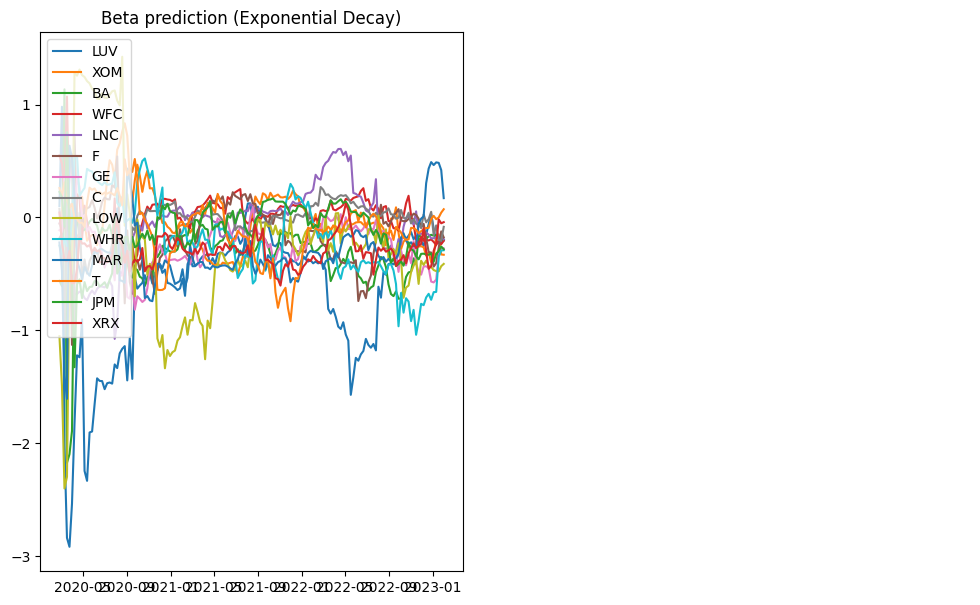

In [20]:
H=G

## exponential decay weight regression with half-time H

beta_pred_exp = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index[G:])

for ticker in list_tickers:
    print(ticker)

    for i in range(G+1, len(CDS_wednesday_to_wednesday)):
        date_i = CDS_wednesday_to_wednesday.index[i]
        dates_rho = CDS_wednesday_to_wednesday.index[i-G:i]
        dates_rho = dates_rho.intersection(adj_close_price_equities_wednesday.index)
        j = i-1
        date_j = CDS_wednesday_to_wednesday.index[j]
        dates_c = CDS_wednesday_to_wednesday.index[j-G:j]
        dates_c = dates_c.intersection(spy_data_wednesday.index)
        
        beta_index_i = beta_index[ticker].loc[date_i]
        beta_equity_i = beta_equity[ticker].loc[date_i]
        beta_spy_j = beta_spy[ticker].loc[date_j]
        condition = np.isnan(beta_equity_i) or np.isnan(beta_index_i) or np.isnan(beta_spy_j)
        if condition:
            beta_pred_exp.loc[date_i, ticker] = np.nan
            continue
        
        CDS_returns_i = CDS_wednesday_to_wednesday.loc[dates_rho][ticker + '_CDS_return']
        CDS_market_i = CDS_wednesday_to_wednesday.loc[dates_rho]['CDS_market']
        equity_return_i = adj_close_price_equities_wednesday.loc[dates_rho][ticker + '_return']
        spy_return_j = spy_data_wednesday.loc[dates_c]['SPY_return']
        equity_return_j = adj_close_price_equities_wednesday.loc[dates_c][ticker + '_return']
        
        rho = CDS_returns_i - beta_index_i * CDS_market_i - beta_equity_i * equity_return_i
        c = equity_return_j - beta_spy_j * spy_return_j
        c.index = c.index + pd.Timedelta(weeks=1)
        
        c.name, rho.name = 'c', 'rho'
        temp_data = pd.merge(rho, c, left_index=True, right_index=True)
        
        if len(temp_data) < 2:
            beta_pred_exp.loc[date_i, ticker] = np.nan
            continue
        
        # Exponential decay weights
        time_diffs = (date_i - temp_data.index).days / 7  # Convert to weeks
        weights = np.exp(-np.log(2) * time_diffs / H)
        
        # Weighted regression
        model = sm.WLS(temp_data['rho'], temp_data['c'], weights=weights).fit()
        beta_pred_exp.loc[date_i, ticker] = model.params['c']
        
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
for ticker in list_tickers:
    ax[0].plot(beta_pred_exp.dropna().index, beta_pred_exp.dropna()[ticker], label=ticker)
ax[0].set_title('Beta prediction (Exponential Decay)')
ax[0].legend(loc='upper left')
ax[1].axis('off')
plt.show()


The beta values are very similar to box car. Let try with a lower H values to see how it changes

LUV
XOM
BA
WFC
LNC
F
GE
C
LOW
WHR
MAR
T
JPM
XRX


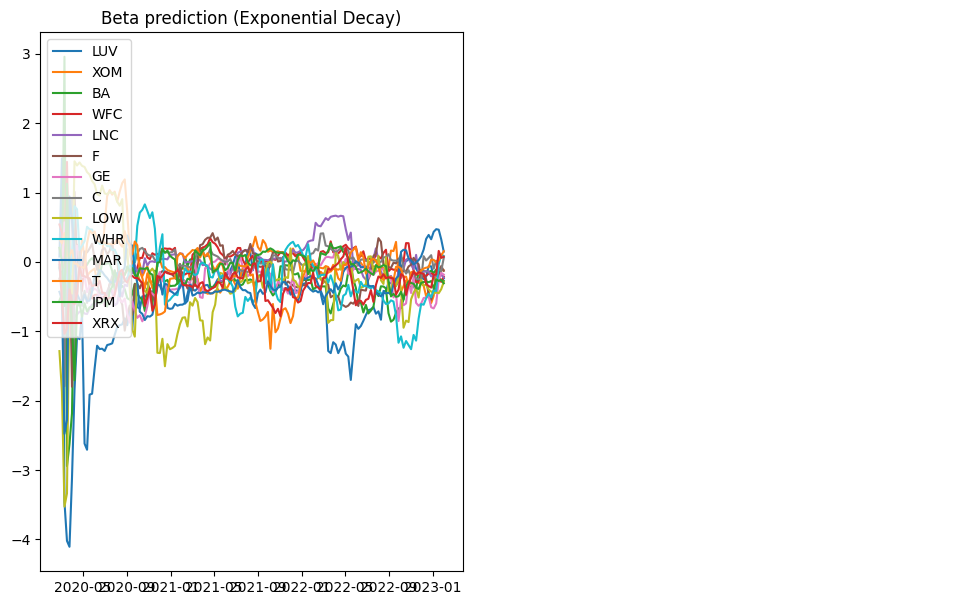

In [48]:
H=5

## exponential decay weight regression with half-time H

beta_pred_exp = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index)

for ticker in list_tickers:
    print(ticker)

    for i in range(G+1, len(CDS_wednesday_to_wednesday)):
        date_i = CDS_wednesday_to_wednesday.index[i]
        dates_rho = CDS_wednesday_to_wednesday.index[i-G:i]
        dates_rho = dates_rho.intersection(adj_close_price_equities_wednesday.index)
        j = i-1
        date_j = CDS_wednesday_to_wednesday.index[j]
        dates_c = CDS_wednesday_to_wednesday.index[j-G:j]
        dates_c = dates_c.intersection(spy_data_wednesday.index)
        
        beta_index_i = beta_index[ticker].loc[date_i]
        beta_equity_i = beta_equity[ticker].loc[date_i]
        beta_spy_j = beta_spy[ticker].loc[date_j]
        condition = np.isnan(beta_equity_i) or np.isnan(beta_index_i) or np.isnan(beta_spy_j)
        if condition:
            beta_pred_exp.loc[date_i, ticker] = np.nan
            continue
        
        CDS_returns_i = CDS_wednesday_to_wednesday.loc[dates_rho][ticker + '_CDS_return']
        CDS_market_i = CDS_wednesday_to_wednesday.loc[dates_rho]['CDS_market']
        equity_return_i = adj_close_price_equities_wednesday.loc[dates_rho][ticker + '_return']
        spy_return_j = spy_data_wednesday.loc[dates_c]['SPY_return']
        equity_return_j = adj_close_price_equities_wednesday.loc[dates_c][ticker + '_return']
        
        rho = CDS_returns_i - beta_index_i * CDS_market_i - beta_equity_i * equity_return_i
        c = equity_return_j - beta_spy_j * spy_return_j
        c.index = c.index + pd.Timedelta(weeks=1)
        
        c.name, rho.name = 'c', 'rho'
        temp_data = pd.merge(rho, c, left_index=True, right_index=True)
        
        if len(temp_data) < 2:
            beta_pred_exp.loc[date_i, ticker] = np.nan
            continue
        
        # Exponential decay weights
        time_diffs = (date_i - temp_data.index).days / 7  # Convert to weeks
        weights = np.exp(-np.log(2) * time_diffs / H)
        
        # Weighted regression
        model = sm.WLS(temp_data['rho'], temp_data['c'], weights=weights).fit()
        beta_pred_exp.loc[date_i, ticker] = model.params['c']
        
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
for ticker in list_tickers:
    ax[0].plot(beta_pred_exp.dropna().index, beta_pred_exp.dropna()[ticker], label=ticker)
ax[0].set_title('Beta prediction (Exponential Decay)')
ax[0].legend(loc='upper left')
ax[1].axis('off')
plt.show()


We can see that for lower H values, the betas are more volatiles. This make sense because we got less important points in our regression, which imply more sensitivity to idiosynchratic return's volatilty

Let's come back to H=G

In [49]:
H=G

## exponential decay weight regression with half-time H

beta_pred_exp = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index)

for ticker in list_tickers:
    for i in range(G+1, len(CDS_wednesday_to_wednesday)):
        date_i = CDS_wednesday_to_wednesday.index[i]
        dates_rho = CDS_wednesday_to_wednesday.index[i-G:i]
        dates_rho = dates_rho.intersection(adj_close_price_equities_wednesday.index)
        j = i-1
        date_j = CDS_wednesday_to_wednesday.index[j]
        dates_c = CDS_wednesday_to_wednesday.index[j-G:j]
        dates_c = dates_c.intersection(spy_data_wednesday.index)
        
        beta_index_i = beta_index[ticker].loc[date_i]
        beta_equity_i = beta_equity[ticker].loc[date_i]
        beta_spy_j = beta_spy[ticker].loc[date_j]
        condition = np.isnan(beta_equity_i) or np.isnan(beta_index_i) or np.isnan(beta_spy_j)
        if condition:
            beta_pred_exp.loc[date_i, ticker] = np.nan
            continue
        
        CDS_returns_i = CDS_wednesday_to_wednesday.loc[dates_rho][ticker + '_CDS_return']
        CDS_market_i = CDS_wednesday_to_wednesday.loc[dates_rho]['CDS_market']
        equity_return_i = adj_close_price_equities_wednesday.loc[dates_rho][ticker + '_return']
        spy_return_j = spy_data_wednesday.loc[dates_c]['SPY_return']
        equity_return_j = adj_close_price_equities_wednesday.loc[dates_c][ticker + '_return']
        
        rho = CDS_returns_i - beta_index_i * CDS_market_i - beta_equity_i * equity_return_i
        c = equity_return_j - beta_spy_j * spy_return_j
        c.index = c.index + pd.Timedelta(weeks=1)
        
        c.name, rho.name = 'c', 'rho'
        temp_data = pd.merge(rho, c, left_index=True, right_index=True)
        
        if len(temp_data) < 2:
            beta_pred_exp.loc[date_i, ticker] = np.nan
            continue
        
        # Exponential decay weights
        time_diffs = (date_i - temp_data.index).days / 7  # Convert to weeks
        weights = np.exp(-np.log(2) * time_diffs / H)
        
        # Weighted regression
        model = sm.WLS(temp_data['rho'], temp_data['c'], weights=weights).fit()
        beta_pred_exp.loc[date_i, ticker] = model.params['c']

## 3. Opportunity


I notice that by setting to Nan when there is not enough data, I loose many week prediction, therefore i going to forward fill to avoid loosing those opportunities bu I am aware this is not a good solution. I should be looking at ho to avoid that

In [50]:
## get beta predicitve model where is not nan and forwards fill
beta_pred_exp= beta_pred_exp.dropna() ## we remove first nan value
## fit other beta indices to beta_pred_exp index and ffill for missing values
beta_index = beta_index.reindex(beta_pred_exp.index).ffill()
beta_equity = beta_equity.reindex(beta_pred_exp.index).ffill()
beta_spy = beta_spy.reindex(beta_pred_exp.index).ffill()


In [51]:
print(adj_close_price_equities_wednesday.index)
print(beta_pred_exp.index)
# print(beta_spy.index)

DatetimeIndex(['2018-01-10', '2018-01-17', '2018-01-24', '2018-01-31',
               '2018-02-07', '2018-02-14', '2018-02-21', '2018-02-28',
               '2018-03-07', '2018-03-14',
               ...
               '2024-10-16', '2024-10-23', '2024-10-30', '2024-11-06',
               '2024-11-13', '2024-11-20', '2024-11-27', '2024-12-04',
               '2024-12-11', '2024-12-18'],
              dtype='datetime64[ns]', name='Date', length=358, freq=None)
DatetimeIndex(['2020-02-26', '2020-03-04', '2020-03-11', '2020-03-18',
               '2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15',
               '2020-04-22', '2020-04-29',
               ...
               '2022-11-30', '2022-12-07', '2022-12-14', '2022-12-21',
               '2022-12-28', '2023-01-04', '2023-01-11', '2023-01-18',
               '2023-01-25', '2023-02-01'],
              dtype='datetime64[ns]', name='date', length=154, freq=None)


We will have to match dates for the trading strategy

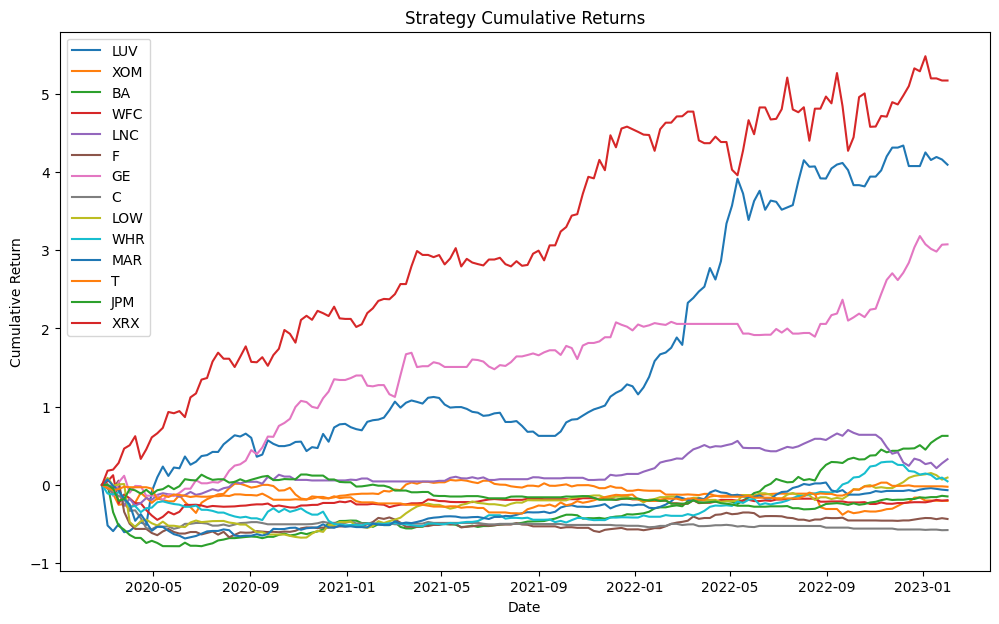

In [52]:

def performance(j, beta_pred, beta_index, beta_equity, beta_spy):
    threshold = j
    ## get beta predicitve model where is not nan and forwards fill
    beta_pred= beta_pred.dropna().copy() ## we remove first nan values
    ## fit other beta indices to beta_pred_exp index and ffill for missing values
    beta_index_aligned = beta_index.reindex(beta_pred.index).ffill().copy()
    beta_equity_aligned = beta_equity.reindex(beta_pred.index).ffill().copy()
    beta_spy_temp = beta_spy.reindex(beta_pred.index).ffill().copy()
    
    adj_close_aligned = adj_close_price_equities_wednesday.copy().reindex(beta_pred.index).ffill()
    spy_aligned = spy_data_wednesday.copy().reindex(beta_pred.index).ffill()
    
    strategy_returns = pd.DataFrame(index=beta_pred.index, columns=list_tickers, dtype=float)
    
    for ticker in list_tickers:
        # c = equity return - beta_spy * SPY return.
        c_series = adj_close_aligned[ticker + '_return'] - beta_spy_temp[ticker] * spy_aligned['SPY_return']
        
        # We use the lagged CAPM residual (from the previous week) for prediction.
        c_lag = c_series.shift(1)
        
        pred_return = beta_pred[ticker] * c_lag.reindex(beta_pred.index).ffill()
        
        # position based on the predicted return.
        position = pred_return.apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))
        
        # Compute actual CDS residual return (rho)
        cds_ret = CDS_wednesday_to_wednesday[ticker + '_CDS_return']
        cds_market = CDS_wednesday_to_wednesday['CDS_market']
        equity_ret = adj_close_price_equities_wednesday[ticker + '_return']
        
        # Reindex to beta_pred.index to avoid missing timestamp errors
        cds_ret_aligned = cds_ret.reindex(beta_pred.index).ffill()
        cds_market_aligned = cds_market.reindex(beta_pred.index).ffill()
        equity_ret_aligned = equity_ret.reindex(beta_pred.index).ffill()
        
        rho = (cds_ret_aligned 
            - beta_index_aligned[ticker] * cds_market_aligned 
            - beta_equity_aligned[ticker] * equity_ret_aligned)
        
        # Simulated weekly P&L is position * rho.
        strategy_returns[ticker] = position * rho


    cumulative_returns = (1 + strategy_returns.fillna(0)).cumprod() - 1
    return strategy_returns, cumulative_returns

_, cumulative_returns = performance(0.001, beta_pred_exp, beta_index, beta_equity, beta_spy)

plt.figure(figsize=(12, 7))
for ticker in list_tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.title("Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left')
plt.show()


In [53]:
def compute_performance_metrics(returns, risk_free_rate=0.0, periods_per_year=52):

    excess_returns = returns - risk_free_rate

    mean_return = excess_returns.mean()
    std_return = excess_returns.std()
    sharpe_ratio = (mean_return / std_return) * np.sqrt(periods_per_year) if std_return != 0 else np.nan
    
    var_level = 0.05
    VaR = returns.quantile(var_level)
    
    CVaR = returns[returns <= VaR].mean()
    
    cumulative = (1 + returns).cumprod()
    # Running maximum of cumulative returns
    running_max = cumulative.cummax()
    # Drawdown = % drop from the running max
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()  # most negative drawdown

    return {
        "Sharpe Ratio": sharpe_ratio,
        "VaR (5%)": VaR,
        "CVaR (5%)": CVaR,
        "Max Drawdown": max_drawdown
    }

# Now compute performance metrics for each ticker in your strategy_returns DataFrame.
performance_metrics = {}
for ticker in list_tickers:
    strategy_returns = performance(0.001, beta_pred_exp, beta_index, beta_equity, beta_spy)[0]
    ret_series = strategy_returns[ticker].dropna()
    performance_metrics[ticker] = compute_performance_metrics(ret_series, risk_free_rate=0.0, periods_per_year=52)

# Create a DataFrame for easier viewing of performance measures.
performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)


     Sharpe Ratio  VaR (5%)  CVaR (5%)  Max Drawdown
LUV      1.100570 -0.067982  -0.168858     -0.604194
XOM     -0.067732 -0.086055  -0.119307     -0.418569
BA       0.605375 -0.105756  -0.188311     -0.785693
WFC     -0.088823 -0.049405  -0.108417     -0.507758
LNC      0.505973 -0.039325  -0.090415     -0.286541
F       -0.238371 -0.091218  -0.165916     -0.685905
GE       1.629881 -0.051173  -0.096648     -0.276964
C       -1.055503 -0.045185  -0.105254     -0.578776
LOW      0.331959 -0.076230  -0.148924     -0.701187
WHR      0.208676 -0.071495  -0.106661     -0.525160
MAR      0.156610 -0.097986  -0.155156     -0.705046
T        0.055902 -0.040302  -0.066759     -0.366724
JPM     -0.142188 -0.044390  -0.065047     -0.393136
XRX      2.010397 -0.064459  -0.086468     -0.178990


Analysis: we can see that we get some low negative returns with high potential positive returns.

Let try to modify j and see the performance

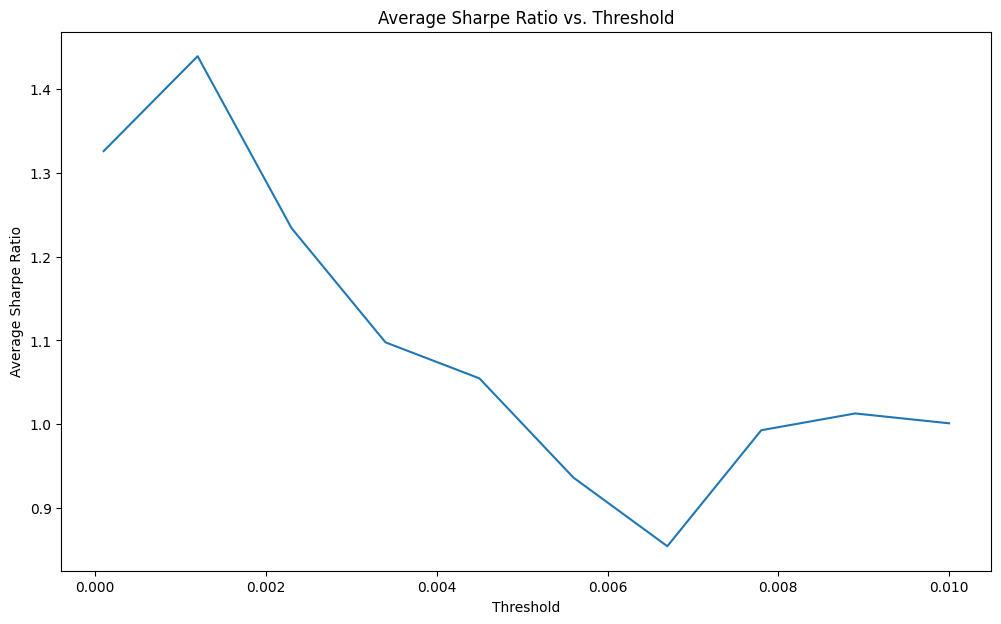

In [54]:
## try for different thresholds and plot average sharpe ratio
thresholds = np.linspace(0.0001, 0.01, 10)
sharpe_ratios = []
for j in thresholds:
    strategy_returns = performance(j, beta_pred_exp, beta_index, beta_equity, beta_spy)[0]
    sharpe_ratio = compute_performance_metrics(strategy_returns.mean(axis=1), risk_free_rate=0.0, periods_per_year=52)['Sharpe Ratio']
    sharpe_ratios.append(sharpe_ratio)

plt.figure(figsize=(12, 7))
plt.plot(thresholds, sharpe_ratios)
plt.title("Average Sharpe Ratio vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average Sharpe Ratio")
plt.show()

We can see that there is a threshold j= 0.001 for which the sharpe ratio is optimal

## Changing G and H

let's try for G=30 and H =15 (to see if more information is better)

In [ ]:

## redefine the process with functions

def get_beta_2_factor_reg(G):
    beta_index = pd.DataFrame(index=CDS_wednesday_to_wednesday.index, columns=list_tickers, dtype=float)
    beta_equity = pd.DataFrame(index=CDS_wednesday_to_wednesday.index, columns=list_tickers, dtype=float)

    for ticker in list_tickers:
        # print("Processing ticker:", ticker)

        y = CDS_wednesday_to_wednesday[ticker + '_CDS_return']
        X = pd.merge(CDS_wednesday_to_wednesday['CDS_market'], adj_close_price_equities_wednesday[ticker + '_return'], left_index=True, right_index=True)
        combined = pd.concat([y, X], axis=1).dropna()
        
        #  if there isn’t enough data for a rolling window add nan values.
        if len(combined) < int(5):
            beta_index[ticker] = np.nan
            beta_equity[ticker] = np.nan
            continue
        
        # Fit the rolling regression and We do not add a constant since alpha is set to zero.
        rolling_model = RollingOLS(endog=combined[ticker + '_CDS_return'],
                                exog=combined[['CDS_market', ticker + '_return']],
                                window=G)
        rolling_res = rolling_model.fit()
        
        # The fitted model returns a DataFrame of parameters with indices corresponding to the last date of each full window.
        params = rolling_res.params

        # Store the estimated coefficients in our beta DataFrames.
        beta_index.loc[params.index, ticker] = params['CDS_market']
        beta_equity.loc[params.index, ticker] = params[ticker + '_return']
    # beta_index, beta_equity = beta_index.dropna(), beta_equity.dropna() 
    return beta_index, beta_equity

def get_beta_CAPM_reg(G):
    beta_spy = pd.DataFrame(index=adj_close_price_equities.index, columns=list_tickers, dtype=float)

    for ticker in list_tickers:
        # print("Processing ticker:", ticker)
        y = adj_close_price_equities_wednesday[ticker + '_return']
        # X is a DataFrame with the market CDS factor and the equity return for the ticker.
        X = spy_data_wednesday['SPY_return']
            
        # combined = pd.concat([y, X], axis=1).dropna()
        combined = pd.merge(y, X, left_index=True, right_index=True)
        
        # Fit the rolling regression and We do not add a constant since alpha is set to zero.
        rolling_model = RollingOLS(endog=combined[[ticker + '_return']],
                                exog=combined[['SPY_return']],
                                window=G)
        rolling_res = rolling_model.fit()
        
        # The fitted model returns a DataFrame of parameters with indices corresponding to the last date of each full window.
        params = rolling_res.params

        # Store the estimated coefficients in our beta DataFrames.
        beta_spy.loc[params.index, ticker] = params['SPY_return']

    # beta_spy = beta_spy.dropna(how='all')
    return beta_spy


def get_beta_pred_exp(H,G, beta_index, beta_equity, beta_spy):
    beta_pred_exp = pd.DataFrame(columns=list_tickers, index=CDS_wednesday_to_wednesday.index)
    
    for ticker in list_tickers:
    # print(ticker)

        for i in range(G+1, len(CDS_wednesday_to_wednesday)):
            date_i = CDS_wednesday_to_wednesday.index[i]
            dates_rho = CDS_wednesday_to_wednesday.index[i-G:i]
            dates_rho = dates_rho.intersection(adj_close_price_equities_wednesday.index)
            j = i-1
            date_j = CDS_wednesday_to_wednesday.index[j]
            dates_c = CDS_wednesday_to_wednesday.index[j-G:j]
            dates_c = dates_c.intersection(spy_data_wednesday.index)
            
            condition = date_i not in beta_index[ticker].index or date_i not in beta_equity[ticker].index or date_j not in beta_spy[ticker].index
            if condition:
                beta_pred_exp.loc[date_i, ticker] = np.nan
                continue
            beta_index_i = beta_index[ticker].loc[date_i]
            beta_equity_i = beta_equity[ticker].loc[date_i]
            beta_spy_j = beta_spy[ticker].loc[date_j]
            
            CDS_returns_i = CDS_wednesday_to_wednesday.loc[dates_rho][ticker + '_CDS_return']
            CDS_market_i = CDS_wednesday_to_wednesday.loc[dates_rho]['CDS_market']
            equity_return_i = adj_close_price_equities_wednesday.loc[dates_rho][ticker + '_return']
            spy_return_j = spy_data_wednesday.loc[dates_c]['SPY_return']
            equity_return_j = adj_close_price_equities_wednesday.loc[dates_c][ticker + '_return']
            
            rho = CDS_returns_i - beta_index_i * CDS_market_i - beta_equity_i * equity_return_i
            c = equity_return_j - beta_spy_j * spy_return_j
            c.index = c.index + pd.Timedelta(weeks=1)
            
            c.name, rho.name = 'c', 'rho'
            temp_data = pd.merge(rho, c, left_index=True, right_index=True)
            
            if len(temp_data) < 2:
                beta_pred_exp.loc[date_i, ticker] = np.nan
                continue
            
            # Exponential decay weights
            time_diffs = (date_i - temp_data.index).days / 7  # Convert to weeks
            weights = np.exp(-np.log(2) * time_diffs / H)
            
            # Weighted regression
            model = sm.WLS(temp_data['rho'], temp_data['c'], weights=weights).fit()
            beta_pred_exp.loc[date_i, ticker] = model.params['c']
    
    return beta_pred_exp

In [79]:
G=20
H=10

## redo the regression (2 factor and CAPM) for G=30 and H=50 with vecorization boxcar and exponential decay for predictive model
beta_index, beta_equity = get_beta_2_factor_reg(G)
beta_spy = get_beta_CAPM_reg(G)
beta_pred_exp = get_beta_pred_exp(H,G, beta_index, beta_equity, beta_spy)


def get_SR_strat(beta_index, beta_equity, beta_spy, beta_pred):    
    thresholds = np.linspace(0.001, 0.1, 100)
    sharpe_ratios = [] 
    for j in thresholds:
        strategy_returns = performance(j, beta_pred_exp, beta_index, beta_equity, beta_spy)[0]
        sharpe_ratio = compute_performance_metrics(strategy_returns.mean(axis=1), risk_free_rate=0.0, periods_per_year=52)['Sharpe Ratio']
        sharpe_ratios.append(sharpe_ratio)

    return sharpe_ratios, thresholds
    
Sharpe_ratio_list, thresholds = get_SR_strat(beta_index, beta_equity, beta_spy, beta_pred_exp)
    

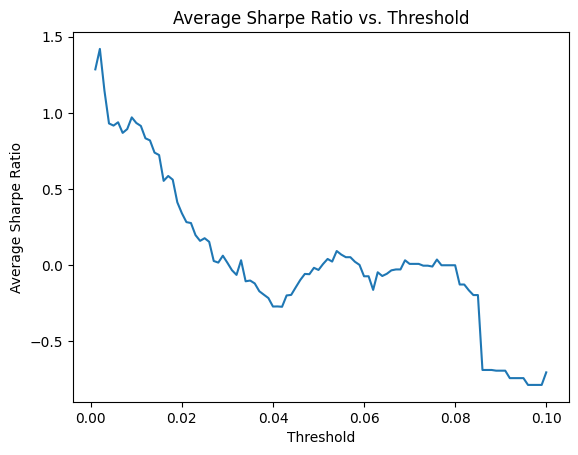

In [80]:
plt.plot(thresholds, Sharpe_ratio_list)
plt.title("Average Sharpe Ratio vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average Sharpe Ratio")
plt.show()

### ANALYSIS

We can see that, overall, the shorter the threshold is, the higher is the sharp ratio. This could mean that taking many trades (because lower threshold) is profitable. I interpret it as a strategy where there is very few false positive signals (i.e trading signal that are wrong).

In [93]:
## try another setup 
G=30
H=20

## redo the regression (2 factor and CAPM) for G=30 and H=50 with vecorization boxcar and exponential decay for predictive model
beta_index, beta_equity = get_beta_2_factor_reg(G)
beta_spy = get_beta_CAPM_reg(G)
beta_pred_exp = get_beta_pred_exp(H,G, beta_index, beta_equity, beta_spy)


def get_SR_strat(beta_index, beta_equity, beta_spy, beta_pred):    
    thresholds = np.linspace(0.001, 0.1, 100)
    sharpe_ratios = []
    for j in thresholds:
        strategy_returns = performance(j, beta_pred, beta_index, beta_equity, beta_spy)[0]
        sharpe_ratio = compute_performance_metrics(strategy_returns.mean(axis=1), risk_free_rate=0.0, periods_per_year=52)['Sharpe Ratio']
        sharpe_ratios.append(sharpe_ratio)

    return sharpe_ratios, thresholds
    
Sharpe_ratio_list, thresholds = get_SR_strat(beta_index, beta_equity, beta_spy, beta_pred_exp)

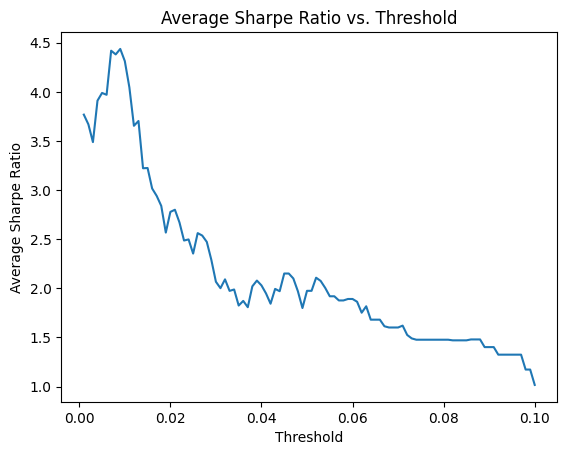

In [94]:
plt.plot(thresholds, Sharpe_ratio_list)
plt.title("Average Sharpe Ratio vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average Sharpe Ratio")
plt.show()

$\textbf{Commentary}$: It looks like the performance is way better for a longer time for regression

### Grid search for optimal Sharpe Ratio for different values for G and H

For each combination of G and H we store the highest Sharpe ration associated with the optimal thresold

In [91]:
list_G = [10, 15, 20, 25, 30, 50]
list_H = [3, 5, 10, 15]

def grid_search_highest_SR(list_G, list_H):
    df_SR = pd.DataFrame(columns=list_H, index=list_G, dtype=float)
    df_thresholds = pd.DataFrame(columns=list_H, index=list_G, dtype=float)
    for G in list_G:
        for H in list_H:
            if H < G:
                beta_index, beta_equity = get_beta_2_factor_reg(G)
                beta_spy = get_beta_CAPM_reg(G)
                beta_pred = get_beta_pred_exp(H, G, beta_index, beta_equity, beta_spy)
                Sharpe_ratio_list, thresholds = get_SR_strat(beta_index, beta_equity, beta_spy, beta_pred)
                df_SR.loc[G, H] = max(Sharpe_ratio_list)
                df_thresholds.loc[G, H] = thresholds[np.argmax(Sharpe_ratio_list)]
    return df_SR, df_thresholds

df_SR, df_thresholds = grid_search_highest_SR(list_G, list_H)

In [97]:
## set col name to be H and index to be G
df_SR.columns.name = 'H'
df_SR.index.name = 'G'
display(df_SR)
df_thresholds.columns.name = 'H'
df_thresholds.index.name = 'G'
display(df_thresholds)

H,3,5,10,15
G,,,,
10,1.089379,1.089379,NaN,NaN
15,1.309936,1.309936,1.309936,NaN
20,1.419876,1.419876,1.419876,1.419876
25,2.510203,2.510203,2.510203,2.510203
30,4.233992,4.233992,4.233992,4.233992
50,4.402360,4.402360,4.402360,4.402360


H,3,5,10,15
G,,,,
10,0.001,0.001,NaN,NaN
15,0.002,0.002,0.002,NaN
20,0.002,0.002,0.002,0.002
25,0.002,0.002,0.002,0.002
30,0.008,0.008,0.008,0.008
50,0.093,0.093,0.093,0.093


$\textbf{Commentary}$: The results show that the maximum sharpe ratio does not depend on the half time value H for the exponential decay predictive regression but is highly dependant on the boxcar window G. It increases as G increases

We aslo see that, as G increases, the optimal threshold is attained at higher value

## Improvment ideas

Try variable threshold such as k*std(returns), for different k.

Try more complex contemporaneous regression (such as fama-french) to identify different idiosynchratic returns.

Try different period for windows. For example, instead of wednesday to wednesday, we could monday to wednesday, then wednesday to friday and close position, or try monthly returns.